In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Start virtual display
# pip install PyVirtualDisplay
# sudo apt-get install xvfb

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

In [3]:
from REINFORCE_helper import RunningVariance
from time import time
from REINFORCE_helper import BaseAgent, format_as_pandas
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.optimizers import Adam, SGD
import keras.backend as K
import numpy as np

Using TensorFlow backend.


In [4]:
class ReinforceAgent(BaseAgent):
    # def __init__(self):
    def actor_critic_loss_continuous(self, advantage, sigma):
        def loss(y_true, y_pred):
            var = K.square(self.noise)
            denom = K.sqrt(2.0 * np.pi * var)
            prob_num = K.exp(- K.square(y_true - y_pred) / (2.0 * var))
            prob = prob_num/denom
            return -K.mean(prob * advantage)
        return loss
    
    def metric(self, sigma):
        def metric(y_true, y_pred):
            return self.noise - sigma
        return metric
    
    def get_policy_model(self, lr=0.001, hidden_layer_neurons = 128, input_shape=[4], output_shape=2):
        state_input = Input(shape=input_shape)
        advantage = Input(shape=(1,))
        x = Dense(hidden_layer_neurons, activation='relu')(state_input)
        mu = Dense(output_shape, activation='tanh')(x)
        sigma = Dense(output_shape, activation='softplus')(x)
        
        model = Model(inputs=[state_input, advantage], outputs=[mu])
        model.compile(Adam(lr), loss=self.actor_critic_loss_continuous(advantage, sigma), metrics=[self.metric(sigma)])
        return model
    
    def get_action(self, eval=False):
        dummy_adv = np.zeros((1, 1))
        p = self.model.predict([self.observation.reshape(1, self.nS), dummy_adv])
        if eval is False:
            action = action_one_hot = p[0] + np.random.normal(loc=0, scale=self.noise, size=p[0].shape)
            # action = action_one_hot = np.clip(action, self.env.action_space.low, self.env.action_space.high)
        else:
            action = action_one_hot = p[0]
        return action, action_one_hot, p
    
    
    def get_entropy(self, preds, epsilon=1e-12):
        # entropy = np.mean(-np.sum(np.log(preds+epsilon)*preds, axis=1)/np.log(self.nA))
        return 1
    
    def get_discounted_rewards(self, r):
        # Por si es una lista
        r = np.array(r, dtype=float)
        """Take 1D float array of rewards and compute discounted reward """
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.gamma + r[t]
            discounted_r[t] = running_add
        return discounted_r 

In [5]:
reinforce_agent = ReinforceAgent('MountainCarContinuous-v0', n_experience_episodes=2, EPISODES=2000, epochs=1, lr=0.001, algorithm='REINFORCE_CAUSAL')

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
reinforce_agent.model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [7]:
obs, actions, preds, disc_sum_rews, rewards, ep_returns, ep_len, last_obs, time_step = reinforce_agent.get_experience_episodes(return_ts=True)

In [8]:
# reinforce_agent = ReinforceAgent('Acrobot-v1', n_experience_episodes=1, EPISODES=2000, epochs=1, lr=0.001, algorithm='REINFORCE_CAUSAL')
# reinforce_agent = ReinforceAgent('LunarLander-v2', n_experience_episodes=50, EPISODES=2000, epochs=5, lr=0.0001, algorithm='REINFORCE_CAUSAL')
reinforce_agent = ReinforceAgent('MountainCarContinuous-v0', n_experience_episodes=1, 
                                 EPISODES=2000, epochs=1, lr=0.001, algorithm='CONTINUOUS_CAUSAL_SIGMA', noise=1.5)

initial_time = time()
running_variance = RunningVariance()


while reinforce_agent.episode < reinforce_agent.EPISODES:
    obs, actions, preds, disc_sum_rews, rewards, ep_returns, ep_len, last_obs = reinforce_agent.get_experience_episodes()
    
    for dr in disc_sum_rews:
        running_variance.add(dr)

    
    history = reinforce_agent.model.fit([obs, disc_sum_rews.reshape(-1, 1)], actions, verbose=0, epochs=reinforce_agent.epochs, batch_size=128)
    
    reinforce_agent.log_data(reinforce_agent.episode, 
                      history.history['loss'][0], 
                      np.mean(ep_len), 
                      reinforce_agent.get_entropy(preds), 
                      running_variance.get_variance(), 
                      history.history['metric'][0], 
                      time() - initial_time, np.mean(ep_returns[-1]))

correr en linea de comando: tensorboard --logdir logs/
Episode: 50
Model on episode 51 improved from -inf to -9.999021614733584. Saved!
Episode: 258
Model on episode 259 improved from -9.999021614733584 to -1.5911020711438164. Saved!
Episode: 518
Model on episode 519 improved from -1.5911020711438164 to 38.758749228926206. Saved!
Episode: 622
Model on episode 623 improved from 38.758749228926206 to 48.11822278726768. Saved!
Episode: 636

KeyboardInterrupt: 

In [ ]:
from matplotlib import pyplot as plt

In [41]:
obs, actions, preds, disc_sum_rews, rewards, ep_returns, ep_len = reinforce_agent.get_eval_episode('MountainCarContinuous.gif', fps=50)

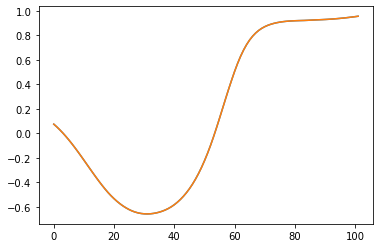

In [42]:
plt.plot(preds)
plt.plot(actions)

In [43]:
obs, actions, preds, disc_sum_rews, rewards, ep_returns, ep_len, last_obs = reinforce_agent.get_experience_episodes()

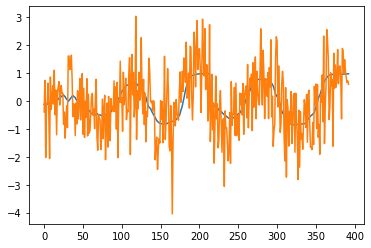

In [44]:
plt.plot(preds)
plt.plot(actions)